I developed a device that could generate EEG's in multiple organisms. This allowed me to perform simple at home experiments to generate data for expected EEG's in various conditions. This code is a major part of that project, in that it allows me to use an Machine Learning Model to find and assess pattern similarities between the datasets and draw meaningful insights into human neuroanatomy.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sys import path
path.append('..')

This cell works to plot the trace, which after processing the data will remove noise and smooth the trace. This helps us visualize the data better before training and making predictions

In [ ]:
def plot_trace(groundtruth=False):


    """
    This is a function to plot the trace given the data, often after processing to remove noise and smooth the trace.
    Parameters:
    groundtruth (bool): Stating whether we have a ground truth signal for comparison. If so, it will overlay, and if not, it will be ignored and the denoised data will be plotted.

    Returns:
    N/A
    """
    plt.figure(figsize=(20,4))

    # First subplot (upper plot)
    plt.subplot(211)
    # Plot the denoised signal
    plt.plot(b+c, lw=2, label='denoised')

    # Check whether there is a ground truth signal for comparison
    if groundtruth:
        plt.plot(true_b+true_c, c='r', label='truth', zorder=-11)

    plt.plot(y, label='data', zorder=-12, c='y')

    # Adds a legend to understand the data
    plt.legend(ncol=3, frameon=False, loc=(.02,.85))


    simpleaxis(plt.gca())

    # Second subplot (lower plot)
    plt.subplot(212)
    # Plot the signal after removing noise and smoothing the trace
    plt.plot(s, lw=2, label='deconvolved', c='g')

    # If groundtruth is True, plot vertical red lines at indices where true_s is nonzero
    if groundtruth:
        for k in np.where(true_s)[0]:
            plt.plot([k,k], [-.1,1], c='r', zorder=-11, clip_on=False)

    plt.ylim(0,1.3)

    # Adds a legend
    plt.legend(ncol=3, frameon=False, loc=(.02,.85))

    simpleaxis(plt.gca())

    # Print correlation between denoised activity s and ground truth EEG
    print("Correlation of denoised activity  with ground truth ('spikes') : %.4f" % np.corrcoef(s,true_s)[0,1])



This  processes uploaded images in Google Colab by extracting black pixel contours, smoothing their average vertical positions across the x-axis, and detecting spike-like features using Gaussian filtering and thresholding. It calculates statistics on spike groupings (like max height and group size) for each image and generates corresponding plots for visualization.











In [ ]:
import numpy as np
import cv2
import os
import glob
from google.colab import files

def gaussian_smoothing(y, window_size=5):
    """

    This function applies Gaussian Smoothin to the trace, using a Guassian kernel to better visualize the trace and make it easier to process.

    Parameters:
    y (numpy array): The input signal to be smoothed.
    window_size (int, optional): Size of the Gaussian kernel window. Default is 5.

    Returns:
    numpy array: The smoothed signal, same shape as the input.
    """
    kernel = np.exp(-np.power(np.arange(window_size) - window_size // 2, 2) / (2 * (window_size // 2)**2))
    kernel /= np.sum(kernel)
    smoothed_signal = np.convolve(y, kernel, mode='same')
    return smoothed_signal

def process_signal(y, window_size=5, noise_threshold=0.16, min_spike_duration=2, smoothing_method='gaussian', std_multiplier=5):
    """

    This function smooths a signal, and detects spike events based on a changing threshold, and returns the filtered spikes. Provides options for smoothing, including Gaussian and Rolling Window
    Defaults have been set for all values based on prior experience with the code

    Parameters:
    y (numpy array): Input signal to process.
    window_size (int, optional): Window size for smoothing.
    noise_threshold (float, optional): Baseline threshold for spike detection.
    min_spike_duration (int, optional): Minimum spike duration (currently unused).
    smoothing_method (str, optional): Smoothing method to use: 'gaussian' or 'rolling_bin'.
    std_multiplier (float, optional): Number of standard deviations added to the threshold.

    Returns:
        - smoothed_signal (numpy array): The smoothed version of the input.
        - spike_durations (list): List of placeholder durations for detected spikes.
        - spike_indices (numpy array ): Indices in the signal where spikes were detected.
    """
    if smoothing_method == 'gaussian':
        smoothed_signal = gaussian_smoothing(y, window_size)
    elif smoothing_method == 'rolling_bin':
        smoothed_signal = rolling_bin_smoothing(y, window_size)
    else:
        raise ValueError("Invalid smoothing_method. Choose 'gaussian' or 'rolling_bin'.")

    signal_std = np.std(smoothed_signal)
    adjusted_threshold = noise_threshold + (std_multiplier * signal_std)
    spike_indices = np.where(smoothed_signal > adjusted_threshold)[0]
    if len(spike_indices) == 0:
        return smoothed_signal, [], []
    spike_durations = [1] * len(spike_indices)
    return smoothed_signal, spike_durations, spike_indices

def calculate_spike_group_features(spike_indices, smoothed_y_values):
    """

    To make sure we are not double counting spikes, we are accounting for spike groups and spike trains. This function groups nearby spikes, and calculates their group feature, including max height, group length, and number of groups.

    Parameters:
    spike_indices (list or numpy array): Indices of detected spikes.
    smoothed_y_values (numpy array): The smoothed signal used to evaluate spike magnitudes.

    Returns:
        - max_heights (list): Maximum y-values in each spike group.
        - group_lengths (list): Number of spikes in each group.
        - num_groups (int): Total number of spike groups.
    """
    group_threshold = 40
    spike_groups = []
    current_group = []

    for i in range(len(spike_indices)):
        current_group.append(spike_indices[i])
        if i + 1 < len(spike_indices) and spike_indices[i + 1] - spike_indices[i] > group_threshold:
            spike_groups.append(current_group)
            current_group = []

    if current_group:
        spike_groups.append(current_group)

    max_heights = [np.max(smoothed_y_values[group]) if group else 0 for group in spike_groups]
    group_lengths = [len(group) for group in spike_groups]
    num_groups = len(spike_groups)

    return max_heights, group_lengths, num_groups

def process_uploaded_images():
    """


    This function takes in the images and calculates statistics for each spike group which can be later used as features.

    Parameters:
    N/A

    Returns:
        - spike_groups_data: List containing per-image spike group metrics:
            {
                'image_path': str,
                'max_heights': list,
                'group_lengths': list,
                'num_groups': int
            }
    """
    uploaded_files = glob.glob('/content/*.jpg') + glob.glob('/content/*.png')

    spike_groups_data = []
    graphs = []

    for image_path in uploaded_files:
        try:
            image = cv2.imread(image_path)
            hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            lower_black = np.array([0, 0, 0])
            upper_black = np.array([180, 255, 40])
            mask_black = cv2.inRange(hsv, lower_black, upper_black)
            y_coords_black, x_coords_black = np.where(np.any(cv2.bitwise_and(image, image, mask=mask_black) != 0, axis=2))

            avg_y_values = {}
            for x, y in zip(x_coords_black, y_coords_black):
                if x in avg_y_values:
                    avg_y_values[x].append(y)
                else:
                    avg_y_values[x] = [y]
            for x in avg_y_values:
                avg_y_values[x] = np.mean(avg_y_values[x])

            x_values = list(avg_y_values.keys())
            y_values = list(avg_y_values.values())
            sorted_indices = np.argsort(x_values)
            x_values_sorted = np.array(x_values)[sorted_indices]
            y_values_sorted = np.array(y_values)[sorted_indices]

            smoothed_y_values = gaussian_smoothing(y_values_sorted, window_size=5)
            filtered_data, spike_durations, spike_indices = process_signal(
                smoothed_y_values,
                window_size=5,
                noise_threshold=200,
                min_spike_duration=2,
                smoothing_method='gaussian'
            )

            max_heights, group_lengths, num_groups = calculate_spike_group_features(spike_indices, smoothed_y_values)

            spike_groups_data.append({
                'image_path': image_path,
                'max_heights': max_heights,
                'group_lengths': group_lengths,
                'num_groups': num_groups
            })

            import matplotlib.pyplot as plt
            plt.figure(figsize=(8, 6))
            plt.plot(x_values_sorted, y_values_sorted[:len(smoothed_y_values)], c='black', marker='.', label='Original Signal')
            plt.plot(x_values_sorted, smoothed_y_values, c='red', label='Smoothed Signal')
            plt.scatter(x_values_sorted[spike_indices], smoothed_y_values[spike_indices], c='blue', marker='x', label='Detected Spikes')
            plt.title(f"Average Y Value of Black Contour Pixels for {image_path}")
            plt.xlabel("X-axis")
            plt.ylabel("Average Y-axis")
            plt.legend()
            graphs.append(plt.gcf())
            plt.close()

        except Exception as e:
            print(f"Error processing image '{image_path}': {e}")

    return spike_groups_data, graphs


spike_groups_data, graphs = process_uploaded_images()

# Access and print spike group data
for data in spike_groups_data:
    print(f"Image: {data['image_path']}")
    print(f"Max Heights: {data['max_heights']}")
    print(f"Group Lengths: {data['group_lengths']}")
    print(f"Number of Groups: {data['num_groups']}")

Image: /content/image3.jpg
Max Heights: [np.float64(962.6561940399887), np.float64(703.8939612110473), np.float64(898.5838747983421), np.float64(837.2260579176939), np.float64(852.3152054501517)]
Group Lengths: [146, 2, 110, 60, 5]
Number of Groups: 5
Image: /content/image9.jpg
Max Heights: [np.float64(898.0114943935694), np.float64(820.03629653842), np.float64(856.6714791427675), np.float64(714.1508435854904), np.float64(794.2797459035334)]
Group Lengths: [141, 112, 35, 8, 3]
Number of Groups: 5
Image: /content/image8.jpg
Max Heights: [np.float64(908.09224186031), np.float64(697.9849138854686), np.float64(891.4855765114871), np.float64(670.7742192061601), np.float64(798.8681915931519), np.float64(836.6359539759811)]
Group Lengths: [134, 16, 114, 2, 68, 11]
Number of Groups: 6
Image: /content/image10.jpg
Max Heights: [np.float64(910.6662381525774), np.float64(940.2729390415944), np.float64(775.8208951875062), np.float64(851.8538492788308)]
Group Lengths: [113, 107, 29, 4]
Number of Gro

This code processes a list of image files by extracting black pixel contours, smoothing the vertical (Y) signal, detecting spike-like events, and grouping them to compute features like spike height and group size. It returns structured data for each image, generates corresponding visual plots, and keeps track of successfully processed files.











Image: image2.jpg
Max Heights: [np.float64(1250.482039881341), np.float64(962.5809089528886), np.float64(1161.8270398552022), np.float64(935.9693638164431), np.float64(999.7328846269023), np.float64(1007.2513838861444)]
Group Lengths: [180, 21, 148, 4, 102, 5]
Number of Groups: 6
Image: image3.jpg
Max Heights: [np.float64(962.6561940399887), np.float64(703.8939612110473), np.float64(898.5838747983421), np.float64(837.2260579176939), np.float64(852.3152054501517)]
Group Lengths: [146, 2, 110, 60, 5]
Number of Groups: 5
Image: image4.jpg
Max Heights: [np.float64(938.2510314373491), np.float64(892.7917473078504), np.float64(821.0513777930817)]
Group Lengths: [135, 116, 14]
Number of Groups: 3
Image: image5.jpg
Max Heights: [np.float64(968.6775150145307), np.float64(886.628807514887), np.float64(836.7417193489351), np.float64(923.2176092870594)]
Group Lengths: [145, 62, 23, 4]
Number of Groups: 4
Image: image6.jpg
Max Heights: [np.float64(1017.3331654228533), np.float64(830.0293248963441),

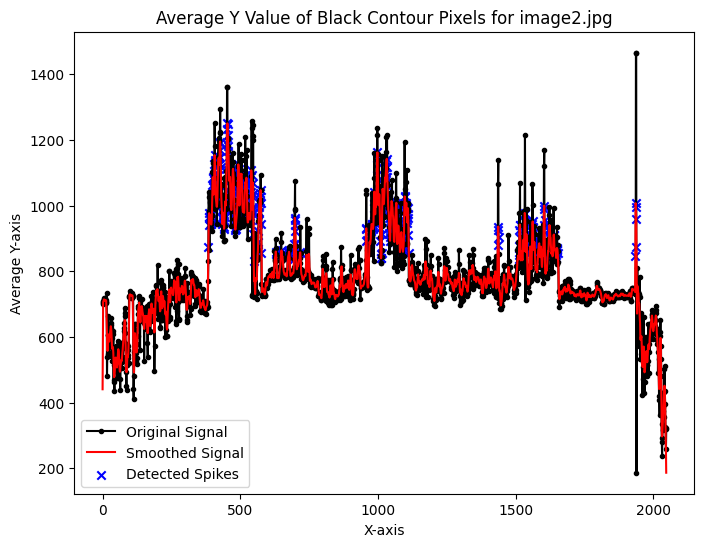

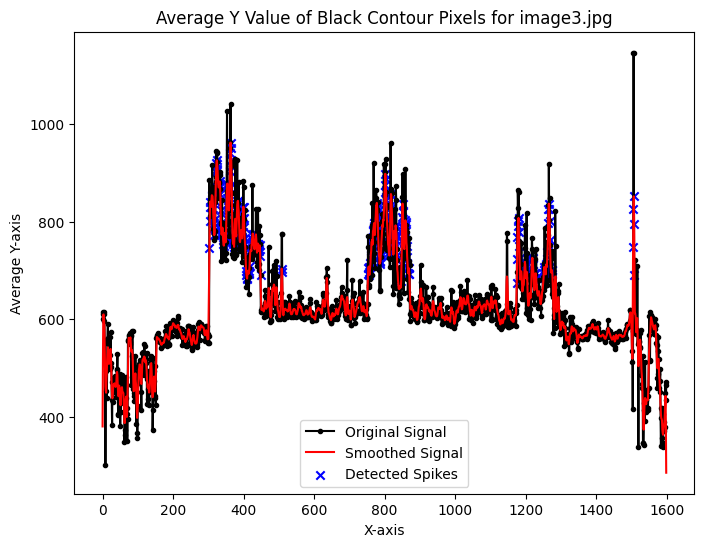

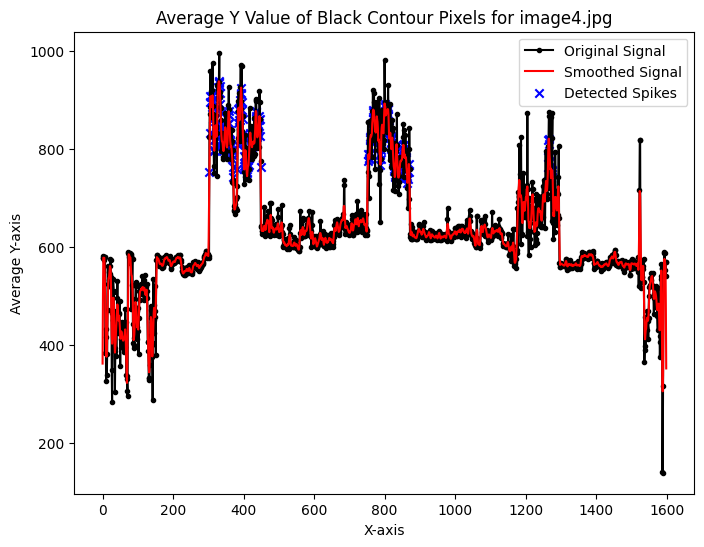

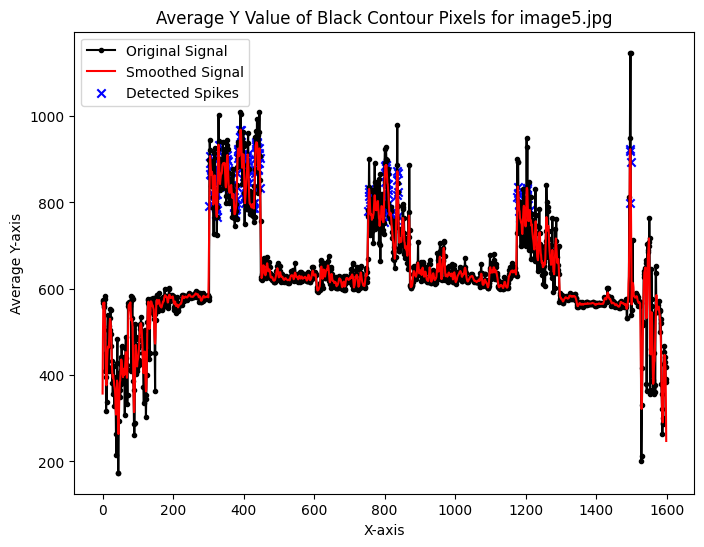

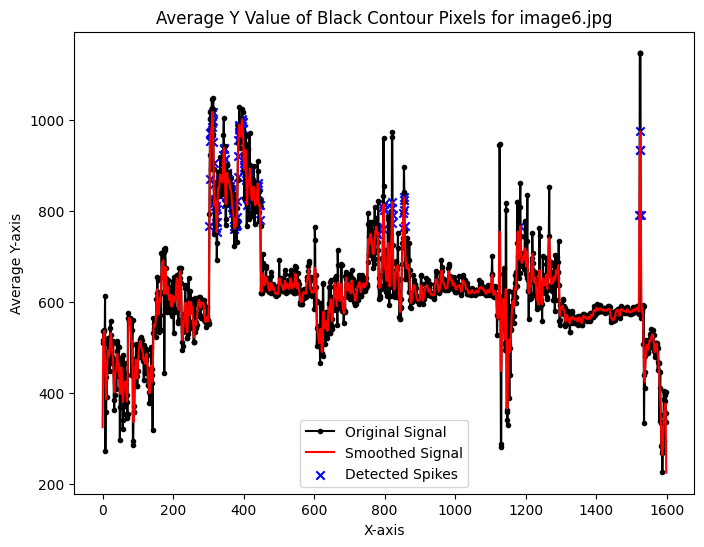

In [ ]:
import numpy as np
import cv2
import os
import glob
from google.colab import files




def process_images(image_paths):
    """

    This function processes the image files paths, to extract the contour features, smooth the contour signal, detect spike events, and generate spike group statistics and visual graphs.

    Parameters:
    image_paths: List of file paths to input images (e.g., .jpg or .png).

    Returns:
        - spike_groups_data: Spike group analysis for each image. Each dict contains:
            - 'image_path': str - Path to the processed image.
            - 'max_heights': list of float - Maximum height (Y-value) in each spike group.
            - 'group_lengths': list of int - Number of spikes in each group.
            - 'num_groups': int - Total number of spike groups.

        - graphs (list of matplotlib.figure.Figure): List of matplotlib figures showing the original,
                                                     smoothed, and spike-annotated signals.

        - processed_image_paths (list of str): List of successfully processed image file paths.
    """
    spike_groups_data = []  # Array for spike group data
    graphs = []  # Array for graphs
    processed_image_paths = []  # Array for processed image paths

    for image_path in image_paths:
        try:
            image = cv2.imread(image_path)
            if image is None:
                print(f"Error: Could not load image {image_path}")
                continue

            hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            lower_black = np.array([0, 0, 0])
            upper_black = np.array([180, 255, 40])
            mask_black = cv2.inRange(hsv, lower_black, upper_black)

            y_coords_black, x_coords_black = np.where(
                np.any(cv2.bitwise_and(image, image, mask=mask_black) != 0, axis=2)
            )

            avg_y_values = {}
            for x, y in zip(x_coords_black, y_coords_black):
                if x in avg_y_values:
                    avg_y_values[x].append(y)
                else:
                    avg_y_values[x] = [y]
            for x in avg_y_values:
                avg_y_values[x] = np.mean(avg_y_values[x])

            x_values = list(avg_y_values.keys())
            y_values = list(avg_y_values.values())
            sorted_indices = np.argsort(x_values)
            x_values_sorted = np.array(x_values)[sorted_indices]
            y_values_sorted = np.array(y_values)[sorted_indices]

            smoothed_y_values = gaussian_smoothing(y_values_sorted, window_size=5)
            filtered_data, spike_durations, spike_indices = process_signal(
                smoothed_y_values,
                window_size=5,
                noise_threshold=200,
                min_spike_duration=2,
                smoothing_method='gaussian'
            )

            max_heights, group_lengths, num_groups = calculate_spike_group_features(spike_indices, smoothed_y_values)

            spike_groups_data.append({
                'image_path': image_path,
                'max_heights': max_heights,
                'group_lengths': group_lengths,
                'num_groups': num_groups
            })

            import matplotlib.pyplot as plt
            plt.figure(figsize=(8, 6))
            plt.plot(x_values_sorted, y_values_sorted[:len(smoothed_y_values)], c='black', marker='.', label='Original Signal')
            plt.plot(x_values_sorted, smoothed_y_values, c='red', label='Smoothed Signal')
            plt.scatter(x_values_sorted[spike_indices], smoothed_y_values[spike_indices], c='blue', marker='x', label='Detected Spikes')
            plt.title(f"Average Y Value of Black Contour Pixels for {image_path}")
            plt.xlabel("X-axis")
            plt.ylabel("Average Y-axis")
            plt.legend()
            graphs.append(plt.gcf())
            plt.close()
            processed_image_paths.append(image_path)

        except Exception as e:
            print(f"Error processing image '{image_path}': {e}")

    return spike_groups_data, graphs, processed_image_paths


image_paths = ['image2.jpg', 'image3.jpg', 'image4.jpg', 'image5.jpg', 'image6.jpg']  # Replace with your image paths
spike_groups_data, graphs, processed_image_paths = process_images(image_paths)

# Access and print spike group data
for data in spike_groups_data:
    print(f"Image: {data['image_path']}")
    print(f"Max Heights: {data['max_heights']}")
    print(f"Group Lengths: {data['group_lengths']}")
    print(f"Number of Groups: {data['num_groups']}")

# Access and display graphs
for graph in graphs:
    display(graph)  # Use display() to show the matplotlib figure

This part of the code first processes and extracts features from the image to help train the model. The model is a simple feed-forward neural network that has a set learning rate and dropout rate. A separately implemented gridsearch was used to determine these values. Two dense layers with 128 and 64 neurons respectively form the model and after each dense layer is a dropout layer as suggested in Srivastava et al., 2014










In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.preprocessing.sequence import pad_sequences








def feature_extraction(image_paths):
    """

    This function processes the images and extracts features and labels to train the model

    Parameters:
        image_paths: A list of image file paths.


    Returns:
            - X: Feature data for model training.
            - y: Labels (activity status) for model training.
            - max_heights: Maximum spike heights for each image.
            - spike_lengths: Spike lengths for each image.
            - y_values_list: A list of Y-values for each image.
            - processed_image_paths: A list of paths for successfully processed images.
    """
    X = []
    y = []
    max_heights = []
    spike_lengths = []
    y_values_list = []
    processed_image_paths = []
    active_images = ['image6.jpg', 'image7.jpg', 'image8.jpg', 'image10.jpg', 'image2.jpg']
    for image_path in image_paths:
        image = cv2.imread(image_path)

        if image is None:
            print(f"Error: Could not load image {image_path}")
            continue

        try:
            hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            lower_black = np.array([0, 0, 0])
            upper_black = np.array([180, 255, 40])
            mask_black = cv2.inRange(hsv, lower_black, upper_black)
            y_coords_black, x_coords_black = np.where(np.any(cv2.bitwise_and(image, image, mask=mask_black) != 0, axis=2))
            avg_y_values = {}
            for x, y_val in zip(x_coords_black, y_coords_black):
                if x in avg_y_values:
                    avg_y_values[x].append(y_val)
                else:
                    avg_y_values[x] = [y_val]
            for x in avg_y_values:
                avg_y_values[x] = np.mean(avg_y_values[x])
            x_values = list(avg_y_values.keys())
            y_values = list(avg_y_values.values())
            sorted_indices = np.argsort(x_values)
            x_values_sorted = np.array(x_values)[sorted_indices]
            y_values_sorted = np.array(y_values)[sorted_indices]
            smoothed_y_values = gaussian_smoothing(y_values_sorted, window_size=5)
            filtered_data, spike_durations, spike_indices = process_signal(smoothed_y_values, window_size=5, noise_threshold=200, min_spike_duration=2, smoothing_method='gaussian')


            X.append(y_values_sorted)
            if os.path.basename(image_path) in active_images:
                y.append(1)
            else:
                y.append(0)
            max_heights.append(np.max(smoothed_y_values[spike_indices]) if spike_indices.size else 0)
            spike_lengths.append(len(spike_indices))
            y_values_list.append(y_values_sorted)
            processed_image_paths.append(image_path)


        except Exception as e:
            print(f"Error processing image '{image_path}': {e}")


    # Convert y to a numpy array after the loop
    y = np.array(y, dtype=np.int64)
    # Pad sequences before converting to numpy array
    max_len = max(len(seq) for seq in X) if X else 0  # Handle empty X
    X_padded = pad_sequences(X, maxlen=max_len, padding='post', dtype='float32')
    X = np.array(X_padded)


    return X, y, max_heights, spike_lengths, y_values_list, processed_image_paths





def create_model(X_train, Y_train, units=64, dropout_rate=0.2, learning_rate=0.001):
    """
    This function creates and trains a simple feed-forward neural network, with a set dropout rate and learning rate. Note that a separately implemented gridsearch was ued to determine these parameters.

    Parameters:
        X_train: Training data.
        Y_train: Training labels.
        units: Number of units in the Dense layers.
        dropout_rate: Dropout rate for regularization.
        learning_rate: Learning rate for the optimizer.

    Returns:
        The trained feed-forward neural network model.
    """

    num_samples = X_train.shape[0]
    timesteps = X_train.shape[1]
    num_features = 1


    X_train_reshaped = X_train.reshape(num_samples, timesteps * num_features)


    X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32) # Convert to Tensor


    model = Sequential()
    model.add(Dense(units=128, activation='relu', input_shape=(timesteps,)))
    model.add(Dropout(0.5))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))


    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


    model.fit(X_train_tensor, Y_train, epochs=8, batch_size=16)

    return model






image_paths = ['image1.jpg', 'image2.jpg', 'image4.jpg']
X_train, Y_train, max_heights, spike_lengths, y_values_list, processed_image_paths_train = feature_extraction(image_paths)



max_timesteps = max(len(x) for x in X_train) if X_train.size else 0 # Handle empty X_train
X_train_padded = pad_sequences(X_train, maxlen=max_timesteps, padding='post', truncating='post', dtype=np.float32)  # Ensure data type is float32



X_train_reshaped = X_train_padded.reshape(X_train_padded.shape[0], X_train_padded.shape[1], 1)
model = create_model(X_train_padded, Y_train) # Expect only the model in return



image_paths_test = ['image10.jpg', 'image11.jpg']
X_test, y_test, max_heights_test, spike_lengths_test, y_values_list_test, processed_image_paths_test = feature_extraction(image_paths_test)


X_test_padded = pad_sequences(X_test, maxlen=max_timesteps, padding='post', truncating='post', dtype=np.float32) # Use max_timesteps from training data and ensure data type is float32

X_test_reshaped = X_test_padded.reshape(X_test_padded.shape[0], X_test_padded.shape[1], 1)


num_images_test = len(processed_image_paths_test) # Use the number of successfully processed images
predictions = model.predict(X_test_padded)
predictions = (predictions > 0.5).astype(int)



accuracy = accuracy_score(y_test, predictions)
# print(f"Model accuracy: {accuracy}") # Prints the accuracy of the model on the test set


# predicted_active = [processed_image_paths_test[i] for i, pred in enumerate(predictions) if pred == 1]
# predicted_inactive = [processed_image_paths_test[i] for i, pred in enumerate(predictions) if pred == 0]


# print("\nPredicted 5 Most Active Images:") # Prints a header for the predicted active images
# for image_path in predicted_active[:5]:
#     print(image_path) # Prints the file paths of the predicted active images

# print("\nPredicted 5 Least Active Images:") # Prints a header for the predicted inactive images
# for image_path in predicted_inactive[:5]:
#     print(image_path) # Prints the file paths of the predicted inactive images

# print(predictions) # Prints the raw prediction array (0 or 1 for each test image)


for i, image_path in enumerate(processed_image_paths_train): # Iterate over processed_image_paths_train
  print(f"Image: {image_path}, Row: {i}") # Prints the image path and its corresponding row index in the training data

  print(X_train[i]) # Prints the padded feature vector for the training image